# BrightnessContrast Operator Example

This example presents brightness and contrast manipulation operation within DALI and how to easily set up a pipeline with it.
## Step-by-step guide
1. Let's start from importing handful of utils and DALI itself.


In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = "images"

used `batch_size` is `1`, to keep things simple. You can always extend it on your own.

2. Next, let's implement the pipelines. We've presented 2 versions of a pipeline. The CPU one does all the processing (i.e. reading file, decoding it and brightness/contrast manipulation) on the CPU, while the other pipeline conducts these operations on the GPU.

In [2]:
class BCCpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(BCCpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.bc = ops.BrightnessContrast(device="cpu", brightness_delta=80, contrast_delta=1.0, output_type=types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.bc(image)
        return image, converted
    
class BCGpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(BCGpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.bc = ops.BrightnessContrast(device="gpu", brightness_delta=0, contrast_delta=.4, output_type=types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.bc(image.gpu())
        return image, converted

The function below is used to actually display result of manipulation. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
def display(output, cpu = True):
    i = 0  # Tweak that to have various images from batch
    img1 = output[0].at(i) if cpu else output[0].as_cpu().at(i)
    img2 = output[1].at(i) if cpu else output[1].as_cpu().at(i)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img1);
    ax[1].imshow(img2);

3. Now let's just build the pipelines, run them and display the results. First the GPU one:

In [4]:
pipegpu = BCGpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipegpu.build()          


In [5]:
gpu_output = pipegpu.run()

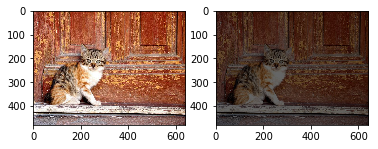

In [6]:
display(gpu_output, cpu=False)

4. And the CPU:

In [7]:
pipecpu = BCCpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

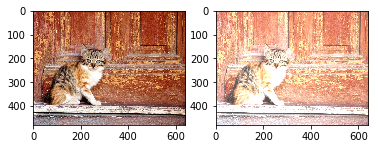

In [8]:
display(cpu_output)